In [1]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)


import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler

In [2]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("df_illgraben_anomaly_scores.parquet")

# --- Read coordinates ---
coords = pd.read_csv(
    "coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [3]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [4]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [8]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [ ]:
df = df_merged.copy()

# Basic cleaning
df = df.dropna(subset=["anomaly_score", "X_mn95", "Y_mn95", "debris flow"])

# Ensure correct types
df["time"] = pd.to_datetime(df["time"])
df["debris flow"] = df["debris flow"].astype(int)


In [17]:
# Aggregate to 1-minute bins per station
df_agg = (
    df.groupby(["station", pd.Grouper(key="time", freq="1min")])
      .agg({
          "anomaly_score": "mean",
          "X_mn95": "first",
          "Y_mn95": "first",
          "Elevation": "first",
          "debris flow": "max"  # if any debris flow in that minute, mark as 1
      })
      .reset_index()
)

In [ ]:
# Feature engineering: include short-term history
# Add lagged anomaly scores (1, 3, 5 minutes before)
for lag in [1, 3, 5]:
    df_agg[f"anomaly_lag_{lag}"] = (
        df_agg.groupby("station")["anomaly_score"].shift(lag)
    )


In [19]:
# Drop rows with missing lags
df_agg = df_agg.dropna(subset=[f"anomaly_lag_{lag}" for lag in [1, 3, 5]])

# Build features and labels
feature_cols = [
    "anomaly_score", "anomaly_lag_1", "anomaly_lag_3", "anomaly_lag_5",
    "X_mn95", "Y_mn95", "Elevation"
]
X = df_agg[feature_cols]
y = df_agg["debris flow"]

# Split data by 2-hour non-overlapping windows
# Sort by time and create 2-hour blocks
df_agg = df_agg.sort_values("time")
block_id = (df_agg["time"].view("int64") // (2 * 3600 * 1e9)).astype(int)
df_agg["block_id"] = block_id


/var/folders/w1/mt9g2b2n36qbnd1y0z2xj9qc0000gn/T/ipykernel_33675/697956785.py:15: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  block_id = (df_agg["time"].view("int64") // (2 * 3600 * 1e9)).astype(int)


In [20]:
# Randomly assign blocks to train/test (no leakage < 2h)
unique_blocks = df_agg["block_id"].unique()
np.random.seed(42)
test_blocks = np.random.choice(unique_blocks, size=int(0.2 * len(unique_blocks)), replace=False)

train_mask = ~df_agg["block_id"].isin(test_blocks)
test_mask  =  df_agg["block_id"].isin(test_blocks)

In [14]:
holdout_station = "ILL12"
train_mask = df["station"] != holdout_station
test_mask = df["station"] == holdout_station

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]


In [22]:
X_train = X.loc[train_mask]
y_train = y.loc[train_mask]
X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

# Standardize spatial + continuous features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# 7️⃣ Train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# 8️⃣ Evaluate
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1386841
           1       0.05      0.85      0.09      2777

    accuracy                           0.97   1389618
   macro avg       0.52      0.91      0.54   1389618
weighted avg       1.00      0.97      0.98   1389618

ROC AUC: 0.9721964243638463


### Attempt 2: Rolling features, threshold optimization

In [96]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Aggregate to 1-minute bins per station
print("Aggregating data to 1-minute bins...")
df_agg = (
    df.groupby(["station", pd.Grouper(key="time", freq="1min")])
      .agg({
          "anomaly_score": "mean",
          "X_mn95": "first", 
          "Y_mn95": "first",
          "Elevation": "first",
          "debris flow": "max"  # Use max to ensure binary output
      })
      .reset_index()
)

# Ensure debris flow is binary (0 or 1)
df_agg["debris flow"] = (df_agg["debris flow"] > 0).astype(int)

print(f"Aggregated data shape: {df_agg.shape}")
print(f"Debris flow distribution: {df_agg['debris flow'].value_counts()}")

# Sort by station and time for proper lag calculation
df_agg = df_agg.sort_values(["station", "time"])

# Feature engineering: include 2-hour history
print("Creating temporal features...")

# Add key lag features (instead of all 120 lags to avoid dimensionality)
key_lags = [1, 5, 10, 15, 30, 45, 60, 90, 120]  # Strategic sampling of 2-hour window

for lag in key_lags:
    df_agg[f"anomaly_lag_{lag}"] = df_agg.groupby("station")["anomaly_score"].shift(lag)

# Add rolling statistics for the 2-hour window
df_agg["anomaly_2h_mean"] = df_agg.groupby("station")["anomaly_score"].transform(
    lambda x: x.rolling(120, min_periods=1).mean()
)
df_agg["anomaly_2h_max"] = df_agg.groupby("station")["anomaly_score"].transform(
    lambda x: x.rolling(120, min_periods=1).max()
)
df_agg["anomaly_2h_std"] = df_agg.groupby("station")["anomaly_score"].transform(
    lambda x: x.rolling(120, min_periods=1).std()
)

# Drop rows with insufficient history
initial_rows = len(df_agg)
df_agg = df_agg.dropna(subset=[f"anomaly_lag_{key_lags[-1]}"])

print(f"Dropped {initial_rows - len(df_agg)} rows with insufficient history")
print(f"Final data shape: {df_agg.shape}")

# Build features
feature_cols = [
    "anomaly_score", "X_mn95", "Y_mn95", "Elevation",
    "anomaly_2h_mean", "anomaly_2h_max", "anomaly_2h_std"
] + [f"anomaly_lag_{lag}" for lag in key_lags]

X = df_agg[feature_cols]
y = df_agg["debris flow"]

# Verify target variable is binary
print(f"\nTarget variable unique values: {sorted(y.unique())}")
print(f"Class distribution: {y.value_counts()}")

# Proper station-based split for ILL12 prediction
holdout_station = "ILL12"

train_mask = df_agg["station"] != holdout_station
test_mask = df_agg["station"] == holdout_station

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"\nData split:")
print(f"Training samples: {len(X_train):,}, Events: {y_train.sum()} ({y_train.mean():.4%})")
print(f"Test samples (ILL12): {len(X_test):,}, Events: {y_test.sum()} ({y_test.mean():.4%})")

# Check for any continuous values in target
if not set(y_train.unique()).issubset({0, 1}):
    print("WARNING: Target contains non-binary values!")
    print(f"Unique values in y_train: {sorted(y_train.unique())}")
    # Force to binary
    y_train = (y_train > 0).astype(int)
    y_test = (y_test > 0).astype(int)

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest with better handling of class imbalance
print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,  # Reduced for speed
    max_depth=15,
    class_weight="balanced_subsample",  # Better for imbalanced data
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# Evaluate
print("\n" + "="*60)
print("RESULTS FOR ILL12 STATION PREDICTION")
print("="*60)

y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Additional diagnostics
print(f"\nAdditional Diagnostics:")
print(f"Training set class balance: {y_train.mean():.6f}")
print(f"Test set class balance: {y_test.mean():.6f}")
print(f"Number of features: {len(feature_cols)}")

Aggregating data to 1-minute bins...
Aggregated data shape: (6896261, 7)
Debris flow distribution: debris flow
0    6865974
1      30287
Name: count, dtype: int64
Creating temporal features...
Dropped 960 rows with insufficient history
Final data shape: (6895301, 19)

Target variable unique values: [np.int64(0), np.int64(1)]
Class distribution: debris flow
0    6865014
1      30287
Name: count, dtype: int64

Data split:
Training samples: 6,059,772, Events: 27051 (0.4464%)
Test samples (ILL12): 835,529, Events: 3236 (0.3873%)
Standardizing features...
Training Random Forest...

RESULTS FOR ILL12 STATION PREDICTION
              precision    recall  f1-score   support

           0      1.000     0.950     0.974    832293
           1      0.068     0.942     0.126      3236

    accuracy                          0.950    835529
   macro avg      0.534     0.946     0.550    835529
weighted avg      0.996     0.950     0.971    835529

ROC AUC: 0.9848

Top 10 Most Important Features:
   

### Attempt 3: Threshold Optimization, Class Balancing, Time-Sensitive Cross-Validation
- trains only on past 
- predicts on 2-hour-ahead windows
- optimizes threshold for best F1 on debris-flow events
- balances class imbalance

## Simplified

In [136]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve,
    average_precision_score, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering (Simplified)
def create_simple_features(group):
    """Create essential temporal features"""
    group = group.sort_values("time").copy()
    
    # Use only rolling statistics (no lag features)
    windows = ["5min", "30min", "60min", "120min"]
    
    for window in windows:
        # Rolling statistics for anomaly_score only
        roll = group.set_index("time")["anomaly_score"].rolling(window, min_periods=1)
        window_str = window.replace("min", "m")
        group[f"anomaly_mean_{window_str}"] = roll.mean().values
        group[f"anomaly_max_{window_str}"] = roll.max().values
        group[f"anomaly_std_{window_str}"] = roll.std().values
    
    return group

print("Creating features...")
df_2020 = df_2020.groupby("station", group_keys=False).apply(create_simple_features)
print("Features created.\n")

# Feature Selection
features = [
    "anomaly_score", "std",
    "anomaly_mean_5m", "anomaly_max_5m", "anomaly_std_5m",
    "anomaly_mean_30m", "anomaly_max_30m", "anomaly_std_30m",
    "anomaly_mean_60m", "anomaly_max_60m", "anomaly_std_60m",
    "anomaly_mean_120m", "anomaly_max_120m", "anomaly_std_120m",
    "X_mn95", "Y_mn95", "Elevation", "hour", "day_of_year"
]

# Remove features with too many NaNs
feature_completeness = df_2020[features].notna().mean()
valid_features = feature_completeness[feature_completeness > 0.95].index.tolist()

print(f"Using {len(valid_features)} features:")
for f in valid_features:
    print(f"  - {f}")
print()

X = df_2020[valid_features].copy()
y = df_2020["debris flow"].astype(int)
time_col = df_2020["time"]
station_col = df_2020["station"]

# PROPER Time-Based Cross-Validation
def create_proper_time_based_splits(df, n_splits=5, gap_minutes=120):
    """
    Create proper chronological time splits
    """
    df = df.sort_values("time").reset_index(drop=True)
    
    # Get the overall date range
    start_date = df["time"].min()
    end_date = df["time"].max()
    total_days = (end_date - start_date).days
    
    print(f"Data range: {start_date.date()} to {end_date.date()} ({total_days} days)")
    
    # Calculate days per fold
    days_per_fold = total_days // n_splits
    print(f"Creating {n_splits} folds with ~{days_per_fold} days per fold")
    
    fold_count = 0
    for i in range(n_splits):
        # Define test period (future)
        test_start_day = (i + 1) * days_per_fold  # Start from fold 1, not 0
        test_end_day = (i + 2) * days_per_fold
        
        # Handle last fold
        if i == n_splits - 1:
            test_end_day = total_days
        
        test_start = start_date + pd.Timedelta(days=test_start_day)
        test_end = start_date + pd.Timedelta(days=test_end_day)
        
        # Training period (past only)
        train_start = start_date
        train_end = test_start - pd.Timedelta(minutes=1)
        
        # Skip if no meaningful training data
        if (train_end - train_start).days < 7:  # At least 1 week of training
            print(f"Fold {i+1}: Skipped - insufficient training data (< 7 days)")
            continue
        
        # Create masks
        train_mask = (df["time"] >= train_start) & (df["time"] <= train_end)
        test_mask = (df["time"] >= test_start) & (df["time"] <= test_end)
        
        # Safety buffer for test period
        test_data = df[test_mask].copy()
        if len(test_data) > 0:
            test_start_safe = test_data["time"].min() + pd.Timedelta(minutes=gap_minutes)
            test_mask_safe = test_mask & (df["time"] >= test_start_safe)
        else:
            test_mask_safe = test_mask
        
        train_idx = df[train_mask].index.values
        test_idx = df[test_mask_safe].index.values
        
        # Only yield if we have events in both sets
        if (len(train_idx) > 0 and len(test_idx) > 0 and 
            y.iloc[train_idx].sum() > 0 and y.iloc[test_idx].sum() > 0):
            
            fold_count += 1
            train_samples = len(train_idx)
            test_samples = len(test_idx)
            train_events = y.iloc[train_idx].sum()
            test_events = y.iloc[test_idx].sum()
            
            print(f"\nFold {fold_count}:")
            print(f"  Train: {train_start.date()} to {train_end.date()}")
            print(f"  Test:  {test_start.date()} to {test_end.date()}") 
            print(f"  Samples: {train_samples:,} train, {test_samples:,} test")
            print(f"  Events:  {train_events} train, {test_events} test")
            
            yield train_idx, test_idx

# Simplified Modeling Pipeline
def create_simple_pipeline():
    """Create simplified pipeline with SMOTE"""
    return ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=50,
            min_samples_leaf=20,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

# Training Loop
print("=== PROPER TIME-BASED CROSS-VALIDATION ===")
print("Training on PAST data, testing on FUTURE data only\n")

all_results = []
feature_importances = []
df_predictions = pd.DataFrame()

fold = 1
for train_idx, test_idx in create_proper_time_based_splits(df_2020, n_splits=5):
    print(f"\n{'='*50}")
    print(f"FOLD {fold}")
    print(f"{'='*50}")
    
    # Get splits
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f"Training samples: {len(X_train):,}, Events: {y_train.sum()} ({y_train.mean():.4%})")
    print(f"Test samples: {len(X_test):,}, Events: {y_test.sum()} ({y_test.mean():.4%})")
    
    # Train model
    pipeline = create_simple_pipeline()
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold based on F1-score
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores[:-1])]
    
    # Final predictions
    y_pred = (y_proba >= best_threshold).astype(int)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    # Store results
    all_results.append({
        'fold': fold,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'best_threshold': best_threshold,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'test_events': y_test.sum()
    })
    
    # Store feature importances
    rf_model = pipeline.named_steps['classifier']
    fold_importance = pd.DataFrame({
        'feature': valid_features,
        'importance': rf_model.feature_importances_,
        'fold': fold
    })
    feature_importances.append(fold_importance)
    
    # Store predictions for analysis
    fold_predictions = pd.DataFrame({
        'time': time_col.iloc[test_idx].values,
        'station': station_col.iloc[test_idx].values,
        'y_true': y_test.values,
        'y_proba': y_proba,
        'y_pred': y_pred,
        'fold': fold
    })
    df_predictions = pd.concat([df_predictions, fold_predictions], ignore_index=True)
    
    # Print fold results
    print(f"\nBest threshold: {best_threshold:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"PR-AUC: {pr_auc:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    fold += 1

# Results Analysis
if all_results:
    results_df = pd.DataFrame(all_results)
    
    print("\n" + "="*60)
    print("FINAL CROSS-VALIDATION RESULTS")
    print("="*60)
    print(f"Completed folds: {len(results_df)}")
    print(f"Mean ROC-AUC: {results_df['roc_auc'].mean():.3f} ± {results_df['roc_auc'].std():.3f}")
    print(f"Mean PR-AUC: {results_df['pr_auc'].mean():.3f} ± {results_df['pr_auc'].std():.3f}")
    print(f"Average test events per fold: {results_df['test_events'].mean():.1f}")
    print("="*60)
    
    # Feature Importance Analysis
    importance_df = pd.concat(feature_importances)
    avg_importance = importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
    
    print("\nTOP 10 FEATURES:")
    for feature, imp in avg_importance.head(10).items():
        print(f"  {feature}: {imp:.4f}")
    
    # Rest of your analysis code remains the same...
    # [Include your existing plotting and event detection code here]

else:
    print("No valid folds completed!")

print("\n✅ Pipeline complete with PROPER temporal validation!")

Creating features...
Features created.

Using 19 features:
  - anomaly_score
  - std
  - anomaly_mean_5m
  - anomaly_max_5m
  - anomaly_std_5m
  - anomaly_mean_30m
  - anomaly_max_30m
  - anomaly_std_30m
  - anomaly_mean_60m
  - anomaly_max_60m
  - anomaly_std_60m
  - anomaly_mean_120m
  - anomaly_max_120m
  - anomaly_std_120m
  - X_mn95
  - Y_mn95
  - Elevation
  - hour
  - day_of_year

=== PROPER TIME-BASED CROSS-VALIDATION ===
Training on PAST data, testing on FUTURE data only

Data range: 2020-05-01 to 2020-09-30 (152 days)
Creating 5 folds with ~30 days per fold

Fold 1:
  Train: 2020-05-01 to 2020-05-30
  Test:  2020-05-31 to 2020-06-30
  Samples: 177,948 train, 413,412 test
  Events:  673 train, 1713 test

FOLD 1
Training samples: 177,948, Events: 673 (0.3782%)
Test samples: 413,412, Events: 1713 (0.4144%)

Best threshold: 0.770
ROC-AUC: 0.988
PR-AUC: 0.639

Classification Report:
              precision    recall  f1-score   support

           0      0.998     0.999     0.999 

EVENT-BASED DETECTION ANALYSIS

📊 Station: ILL11
   Total events: 2
   Detected events: 1
   Event-based recall: 50.000%
   Minute-based recall: 65.730%
   Average event duration: 89.0 minutes
   Detection rate by duration:
     61-1000min: 50.0% (2 events)

📊 Station: ILL12
   Total events: 10
   Detected events: 9
   Event-based recall: 90.000%
   Minute-based recall: 60.116%
   Average event duration: 86.0 minutes
   Detection rate by duration:
     16-60min: 80.0% (5 events)
     61-1000min: 100.0% (5 events)

📊 Station: ILL13
   Total events: 9
   Detected events: 7
   Event-based recall: 77.778%
   Minute-based recall: 48.800%
   Average event duration: 111.1 minutes
   Detection rate by duration:
     16-60min: 0.0% (1 events)
     61-1000min: 87.5% (8 events)

📊 Station: ILL14
   Total events: 4
   Detected events: 0
   Event-based recall: 0.000%
   Minute-based recall: 0.000%
   Average event duration: 103.5 minutes
   Detection rate by duration:
     61-1000min: 0.0% (4 event

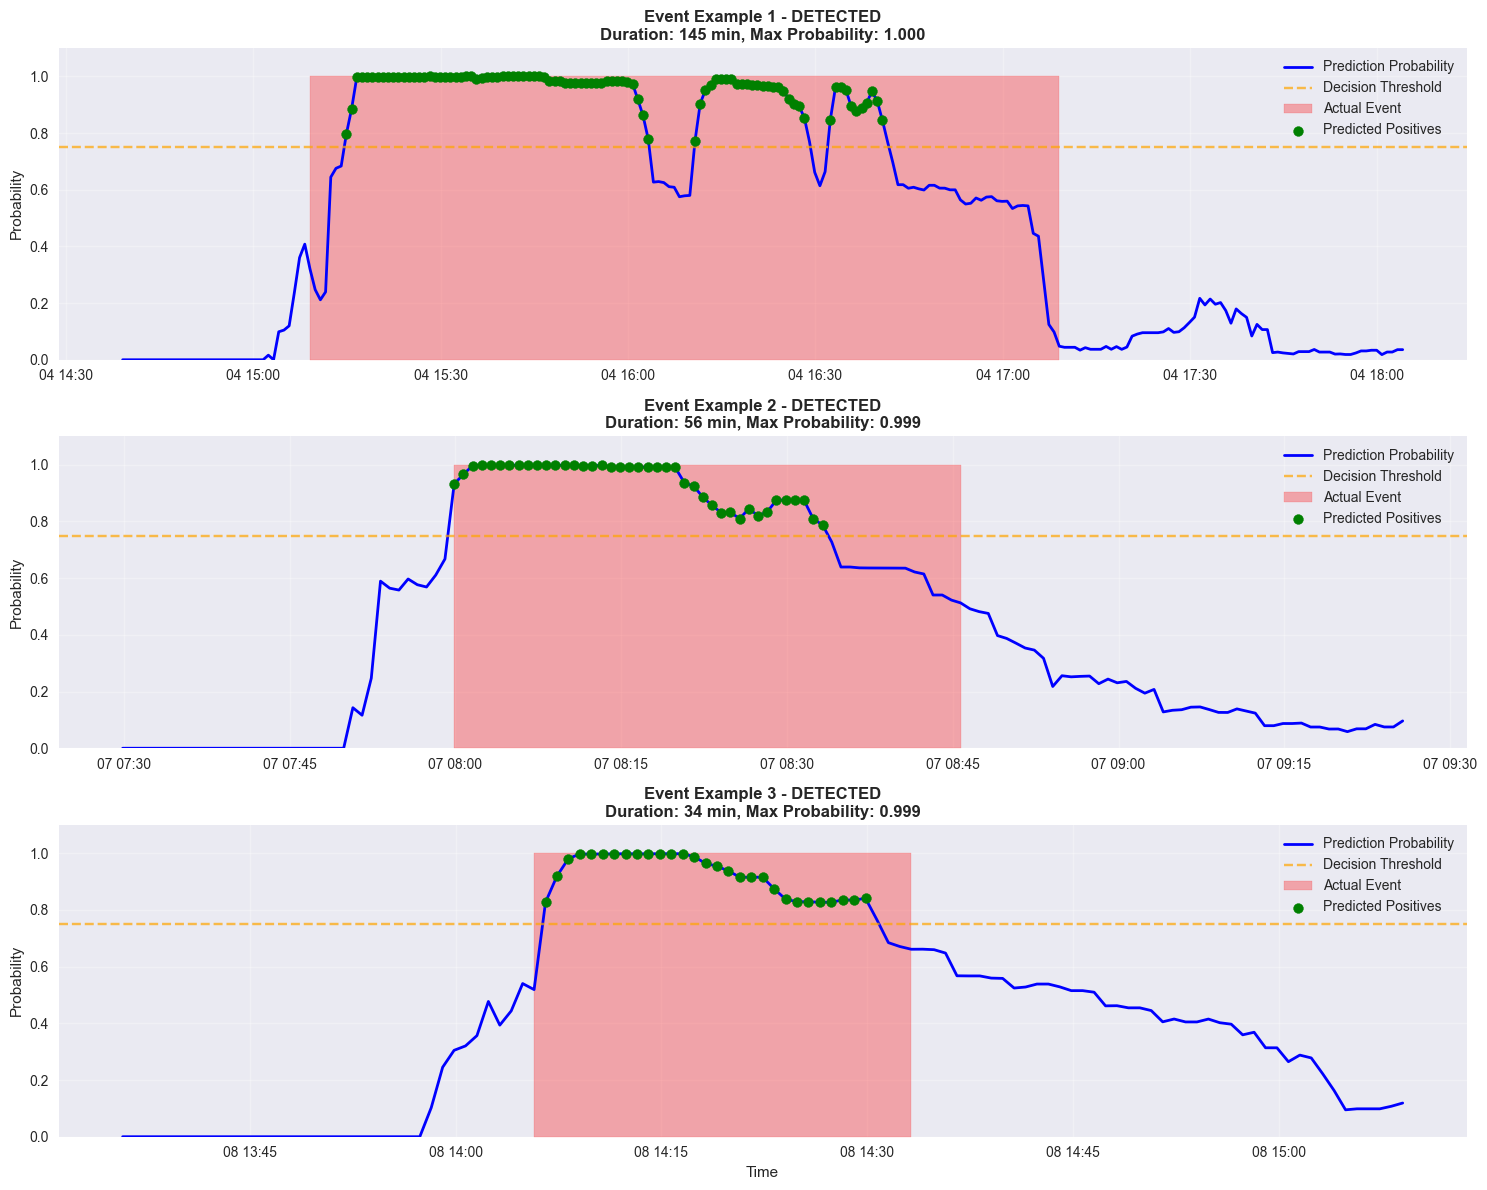

In [137]:

# EVENT-BASED DETECTION ANALYSIS
def analyze_event_based_detection(df_predictions, station=None, min_event_gap_minutes=10):
    """
    Analyze detection at the event level rather than minute level
    An 'event' is defined as consecutive debris flow minutes with gaps < min_event_gap_minutes
    """
    
    if station:
        data = df_predictions[df_predictions['station'] == station].copy()
    else:
        data = df_predictions.copy()
    
    data = data.sort_values(['station', 'time'])
    

    print("EVENT-BASED DETECTION ANALYSIS")

    
    all_events_summary = []
    
    for station_name in data['station'].unique():
        station_data = data[data['station'] == station_name].copy()
        
        # Identify debris flow events (groups of consecutive positive minutes)
        station_data = station_data.sort_values('time')
        station_data['time_diff'] = station_data['time'].diff().dt.total_seconds() / 60  # minutes
        station_data['new_event'] = (station_data['y_true'] == 1) & (
            (station_data['time_diff'] > min_event_gap_minutes) | 
            (station_data['y_true'].shift(1) == 0)
        )
        station_data['event_id'] = station_data['new_event'].cumsum()
        
        # Filter only event periods
        event_data = station_data[station_data['y_true'] == 1]
        
        if len(event_data) == 0:
            continue
            
        # Analyze each event
        events_summary = []
        for event_id, event_group in event_data.groupby('event_id'):
            event_info = {
                'station': station_name,
                'event_id': event_id,
                'start_time': event_group['time'].min(),
                'end_time': event_group['time'].max(),
                'duration_minutes': len(event_group),
                'total_event_minutes': len(event_group),
                'detected_minutes': event_group['y_pred'].sum(),
                'max_probability': event_group['y_proba'].max(),
                'event_detected': event_group['y_pred'].sum() > 0  # Event detected if any minute is detected
            }
            events_summary.append(event_info)
        
        events_df = pd.DataFrame(events_summary)
        all_events_summary.extend(events_summary)
        
        # Station-level summary
        total_events = len(events_df)
        detected_events = events_df['event_detected'].sum()
        event_recall = detected_events / total_events if total_events > 0 else 0
        
        minute_recall = event_data['y_pred'].mean()
        
        print(f"\n📊 Station: {station_name}")
        print(f"   Total events: {total_events}")
        print(f"   Detected events: {detected_events}")
        print(f"   Event-based recall: {event_recall:.3%}")
        print(f"   Minute-based recall: {minute_recall:.3%}")
        print(f"   Average event duration: {events_df['duration_minutes'].mean():.1f} minutes")
        print(f"   Detection rate by duration:")
        for duration_range in [(1, 5), (6, 15), (16, 60), (61, 1000)]:
            range_events = events_df[
                (events_df['duration_minutes'] >= duration_range[0]) & 
                (events_df['duration_minutes'] <= duration_range[1])
            ]
            if len(range_events) > 0:
                detection_rate = range_events['event_detected'].mean()
                print(f"     {duration_range[0]}-{duration_range[1]}min: {detection_rate:.1%} ({len(range_events)} events)")
    
    # Overall summary
    if all_events_summary:
        overall_events_df = pd.DataFrame(all_events_summary)
        total_events = len(overall_events_df)
        detected_events = overall_events_df['event_detected'].sum()
        overall_event_recall = detected_events / total_events
        
        # Compare with minute-based recall
        minute_recall = data[data['y_true'] == 1]['y_pred'].mean()
        
        print(f"\n🎯 OVERALL SUMMARY")
        print(f"   Total events across all stations: {total_events}")
        print(f"   Detected events: {detected_events}")
        print(f"   EVENT-BASED RECALL: {overall_event_recall:.3%}")
        print(f"   MINUTE-BASED RECALL: {minute_recall:.3%}")
        print(f"   Improvement: {((overall_event_recall - minute_recall) / minute_recall):.1%}")
        
        # Detection by event duration
        print(f"\n📈 Detection by Event Duration:")
        duration_bins = [1, 5, 10, 20, 50, 1000]
        for i in range(len(duration_bins)-1):
            low, high = duration_bins[i], duration_bins[i+1]
            bin_events = overall_events_df[
                (overall_events_df['duration_minutes'] >= low) & 
                (overall_events_df['duration_minutes'] < high)
            ]
            if len(bin_events) > 0:
                detection_rate = bin_events['event_detected'].mean()
                avg_duration = bin_events['duration_minutes'].mean()
                print(f"   {low:2d}-{high:3d} min: {detection_rate:.1%} detected (avg: {avg_duration:.1f} min, {len(bin_events)} events)")
        
        return overall_events_df
    else:
        print("No debris flow events found in predictions")
        return None

# ============================================================
# FOLD-BY-FOLD EVENT ANALYSIS
# ============================================================

def analyze_events_by_fold(df_predictions):
    """Analyze event detection for each fold separately"""
    

    print("FOLD-BY-FOLD EVENT DETECTION")

    
    fold_results = []
    
    for fold in sorted(df_predictions['fold'].unique()):
        fold_data = df_predictions[df_predictions['fold'] == fold].copy()
        fold_data = fold_data.sort_values(['station', 'time'])
        
        # Identify events
        fold_data['time_diff'] = fold_data['time'].diff().dt.total_seconds() / 60
        fold_data['new_event'] = (fold_data['y_true'] == 1) & (
            (fold_data['time_diff'] > 10) | 
            (fold_data['y_true'].shift(1) == 0)
        )
        fold_data['event_id'] = fold_data['new_event'].cumsum()
        
        event_data = fold_data[fold_data['y_true'] == 1]
        
        if len(event_data) == 0:
            continue
            
        events_summary = []
        for (station, event_id), event_group in event_data.groupby(['station', 'event_id']):
            event_detected = event_group['y_pred'].sum() > 0
            events_summary.append({
                'fold': fold,
                'station': station,
                'event_id': event_id,
                'duration': len(event_group),
                'detected': event_detected
            })
        
        events_df = pd.DataFrame(events_summary)
        total_events = len(events_df)
        detected_events = events_df['detected'].sum()
        event_recall = detected_events / total_events if total_events > 0 else 0
        minute_recall = event_data['y_pred'].mean()
        
        fold_results.append({
            'fold': fold,
            'total_events': total_events,
            'detected_events': detected_events,
            'event_recall': event_recall,
            'minute_recall': minute_recall
        })
        
        print(f"\nFold {fold}:")
        print(f"  Events: {detected_events}/{total_events} detected")
        print(f"  Event recall: {event_recall:.3%}")
        print(f"  Minute recall: {minute_recall:.3%}")
        
        # Show station breakdown for this fold
        station_summary = events_df.groupby('station').agg({
            'event_id': 'count',
            'detected': 'sum'
        }).reset_index()
        station_summary['recall'] = station_summary['detected'] / station_summary['event_id']
        
        for _, row in station_summary.iterrows():
            print(f"    {row['station']}: {row['detected']}/{row['event_id']} ({row['recall']:.1%})")
    
    # Overall fold comparison
    if fold_results:
        fold_df = pd.DataFrame(fold_results)
        print(f"\n📊 FOLD COMPARISON:")
        for _, row in fold_df.iterrows():
            print(f"  Fold {row['fold']}: Event recall {row['event_recall']:.1%} vs Minute recall {row['minute_recall']:.1%}")
        
        avg_event_recall = fold_df['event_recall'].mean()
        avg_minute_recall = fold_df['minute_recall'].mean()
        print(f"\n🎯 AVERAGE: Event recall {avg_event_recall:.1%} vs Minute recall {avg_minute_recall:.1%}")
        print(f"   Improvement: {((avg_event_recall - avg_minute_recall) / avg_minute_recall):.1%}")

# ============================================================
# RUN THE EVENT-BASED ANALYSIS
# ============================================================

# Analyze overall event detection


# Overall analysis
events_summary_df = analyze_event_based_detection(df_predictions)

# Station-specific analysis (focus on ILL12)
print("ILL12-SPECIFIC EVENT ANALYSIS")
ill12_events = analyze_event_based_detection(df_predictions, station="ILL12")

# Fold-by-fold analysis
analyze_events_by_fold(df_predictions)

# ============================================================
# EVENT DETECTION TIMELINE VISUALIZATION
# ============================================================

def plot_event_detection_examples(df_predictions, station="ILL12", n_examples=3):
    """Plot examples of event detection for visual analysis"""
    
    station_data = df_predictions[df_predictions['station'] == station].copy()
    station_data = station_data.sort_values('time')
    
    # Identify events
    station_data['time_diff'] = station_data['time'].diff().dt.total_seconds() / 60
    station_data['new_event'] = (station_data['y_true'] == 1) & (
        (station_data['time_diff'] > 10) | 
        (station_data['y_true'].shift(1) == 0)
    )
    station_data['event_id'] = station_data['new_event'].cumsum()
    
    # Get events with both true and predicted data
    event_data = station_data[station_data['y_true'] == 1]
    events_with_predictions = []
    
    for event_id, event_group in event_data.groupby('event_id'):
        event_detected = event_group['y_pred'].sum() > 0
        events_with_predictions.append({
            'event_id': event_id,
            'start_time': event_group['time'].min(),
            'detected': event_detected,
            'duration': len(event_group),
            'max_prob': event_group['y_proba'].max()
        })
    
    events_df = pd.DataFrame(events_with_predictions)
    
    # Plot examples
    n_plots = min(n_examples, len(events_df))
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4*n_plots))
    if n_plots == 1:
        axes = [axes]
    
    for i, (_, event) in enumerate(events_df.head(n_plots).iterrows()):
        # Get event period plus some buffer
        event_start = event['start_time'] - pd.Timedelta(minutes=30)
        event_end = event['start_time'] + pd.Timedelta(minutes=event['duration'] + 30)
        
        event_period = station_data[
            (station_data['time'] >= event_start) & 
            (station_data['time'] <= event_end)
        ]
        
        ax = axes[i]
        time = event_period['time']
        
        # Plot prediction probabilities
        ax.plot(time, event_period['y_proba'], 'b-', linewidth=2, label='Prediction Probability')
        ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='Decision Threshold')
        
        # Mark actual event period
        event_mask = (event_period['y_true'] == 1)
        ax.fill_between(time, 0, 1, where=event_mask, 
                       color='red', alpha=0.3, label='Actual Event')
        
        # Mark predicted positives
        pred_positives = event_period[event_period['y_pred'] == 1]
        ax.scatter(pred_positives['time'], pred_positives['y_proba'],
                  color='green', marker='o', s=50, label='Predicted Positives', zorder=5)
        
        detection_status = "DETECTED" if event['detected'] else "MISSED"
        ax.set_title(f'Event Example {i+1} - {detection_status}\n'
                    f'Duration: {event["duration"]} min, Max Probability: {event["max_prob"]:.3f}',
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1.1)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        if i == n_plots - 1:
            ax.set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()

# Plot some event examples

print("EVENT DETECTION EXAMPLES")

plot_event_detection_examples(df_predictions, "ILL12")



Event Definition:

    Consecutive debris flow minutes with gaps <10 minutes

In [138]:
#  PRECISION REPORT


print("PRECISION REPORT - Debris Flow Detection")

# Overall precision across all folds
overall_precision = df_predictions[df_predictions['y_pred'] == 1]['y_true'].mean()

print(f"\n📊 OVERALL PRECISION: {overall_precision:.1%}")
print(f"   When model predicts 'debris flow', it's correct {overall_precision:.1%} of the time")

# Precision by fold
print(f"\n📈 PRECISION BY FOLD:")
for fold in sorted(df_predictions['fold'].unique()):
    fold_data = df_predictions[df_predictions['fold'] == fold]
    fold_precision = fold_data[fold_data['y_pred'] == 1]['y_true'].mean()
    predictions_made = (fold_data['y_pred'] == 1).sum()
    correct_predictions = ((fold_data['y_pred'] == 1) & (fold_data['y_true'] == 1)).sum()
    
    print(f"   Fold {fold}: {fold_precision:.1%} ({correct_predictions}/{predictions_made} correct)")

# Precision by station (focus on ILL12)
print(f"\n🏔️  PRECISION BY STATION:")
for station in ['ILL11', 'ILL12', 'ILL13', 'ILL15', 'ILL16', 'ILL17', 'ILL18']:
    if station in df_predictions['station'].unique():
        station_data = df_predictions[df_predictions['station'] == station]
        station_precision = station_data[station_data['y_pred'] == 1]['y_true'].mean()
        predictions_made = (station_data['y_pred'] == 1).sum()
        correct_predictions = ((station_data['y_pred'] == 1) & (station_data['y_true'] == 1)).sum()
        
        print(f"   {station}: {station_precision:.1%} ({correct_predictions}/{predictions_made} correct)")

# Summary statistics
total_predictions = (df_predictions['y_pred'] == 1).sum()
true_positives = ((df_predictions['y_pred'] == 1) & (df_predictions['y_true'] == 1)).sum()
false_positives = ((df_predictions['y_pred'] == 1) & (df_predictions['y_true'] == 0)).sum()

print(f"\n🔢 SUMMARY STATISTICS:")
print(f"   Total 'debris flow' predictions: {total_predictions:,}")
print(f"   Correct predictions (True Positives): {true_positives:,}")
print(f"   False alarms (False Positives): {false_positives:,}")
print(f"   Precision: {true_positives/total_predictions:.1%}")



PRECISION REPORT - Debris Flow Detection

📊 OVERALL PRECISION: 36.2%
   When model predicts 'debris flow', it's correct 36.2% of the time

📈 PRECISION BY FOLD:
   Fold 1: 75.6% (941/1245 correct)
   Fold 2: 52.2% (181/347 correct)
   Fold 3: 20.0% (464/2320 correct)
   Fold 4: 26.5% (460/1739 correct)

🏔️  PRECISION BY STATION:
   ILL11: 86.0% (117/136 correct)
   ILL12: 65.4% (517/791 correct)
   ILL13: 97.8% (488/499 correct)
   ILL15: 3.9% (4/102 correct)
   ILL16: 18.4% (288/1567 correct)
   ILL17: 16.5% (283/1711 correct)
   ILL18: 51.4% (349/679 correct)

🔢 SUMMARY STATISTICS:
   Total 'debris flow' predictions: 5,651
   Correct predictions (True Positives): 2,046
   False alarms (False Positives): 3,605
   Precision: 36.2%
